# Class 23: Link Prediction

Goal of today's class:
1. Define canonical link prediction tasks
2. Introduce basic measures for link prediction
3. Discuss techniques for evaluating link prediction algorithms

***This lesson is adapted from the 2024 final project of [Yixuan Liu](https://github.com/liu-yi-xuan), a PhD student in Network Science at Northeastern University!***
__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_23/ folder.
________

## Introduction to link prediction in networks

In many real-world systems, networks are not static: new ties appear over time (friendships, collaborations, hyperlinks, trade relations), and sometimes ties disappear. Sometimes, the network was collected with errors present, or there is inherent stochasticity or noise in the link formation process. Our basic predictive task, then, is:

> Given a snapshot of a network at time $t$, which pairs of nodes are currently not connected but either likely will be at time $t + \Delta t$ or *should already be but are not through network noise*?

This formulation covers two closely related problems (Liben-Nowell and Kleinberg, 2007; Lü and Zhou, 2011):

* **Future link prediction**, where we treat the current graph as $G(t)$ and try to anticipate edges that will appear at a later time $t + \Delta t$ but are not yet present.
* **Missing link inference**, where we treat the observed network as a noisy or incomplete version of some latent "true" graph and try to infer edges that should exist but were not observed.

In both cases, the core task is to assign a score $s(i,j)$ to each *non-edge* $(i,j)$ and to rank these candidate pairs by how likely they are to be "real" edges under whatever mechanism we believe is shaping the network.

![](images/link_prediction.png)

### A wide range of application areas

* recommendation systems, where we represent users and items as a bipartite graph and predict which missing user-item edges are most likely to appear in the future;
* social and information networks, where we forecast new friendships, citations, or hyperlinks based on the current topology;
* biological networks, where we infer missing protein-protein interactions or regulatory links that are plausible given the observed interaction structure;
* knowledge graphs, where we attempt to fill in missing relationships between entities.

From a machine learning perspective, link prediction sits at the intersection of **supervised learning** and structured, graph-based modeling. On the one hand, we can treat each node pair $(i,j)$ as an example with a binary label (edge vs non-edge) and learn from features that summarize their structural context ([Liben-Nowell and Kleinberg, 2007](https://onlinelibrary.wiley.com/doi/full/10.1002/asi.20591)). On the other hand, many methods are **unsupervised** in the usual sense: they define scores $s(i,j)$ using purely structural heuristics (for example, common neighbors) or by fitting generative models of network formation (for example, stochastic block models or hierarchical random graphs; [Clauset, Moore, and Newman, 2008](https://www.nature.com/articles/nature06830)).


_______
#### In this chapter we will:
- formalize link prediction as a supervised learning and ranking problem on node pairs;
- construct a simple train/test split by hiding a subset of edges from a known graph;
- implement a set of classical neighborhood-based similarity scores:
    - common neighbors,
    - Jaccard coefficient,
    - Adamic-Adar index,
    - preferential attachment,
    - resource allocation index;
- evaluate these heuristics using ROC-AUC and precision at top-$k$;
- treat these scores as features in a simple logistic regression model;
- examine a case (a disassortative stochastic block model) where local heuristics perform poorly, motivating more expressive generative models;
- connect link prediction to recommendation systems, sparsification, and model-based approaches such as hierarchical random graphs.

Our goal is not to cover modern graph representation learning or graph neural networks, but to build intuition and strong, interpretable baselines using only `networkx` and standard scientific Python. These baselines are both practically useful and conceptually important: they clarify what kinds of structural information are already captured by simple heuristics, and they provide reference points against which more complex models must be justified.

In [1]:
import itertools
import random

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

# For reproducibility

SEED = 42
rng = np.random.default_rng(SEED)
random.seed(SEED)

### A toy network for link prediction

In practice, link prediction is often studied on longitudinal data: we observe the network at multiple time points $\{G(t_0), G(t_1), \dots\}$ and try to predict which non-edges at time $t_i$ become edges at time $t_{i+1}$. Here we approximate this temporal setting by synthetically hiding a subset of edges.

For clarity, we start with a single undirected, unweighted graph $G$ and treat it as if it were a snapshot at some time $t$. We will use a Barabási-Albert graph as a stylized model of a network with a broad, heavy-tailed degree distribution. This is not necessary for link prediction, but it gives us a simple example where degree heterogeneity matters and where neighborhood-based heuristics are non-trivial.

Recall that the BA model grows the network by repeatedly adding new nodes, each of which connects to $m$ existing nodes with probability proportional to their degree ("preferential attachment"). This produces hubs and a skewed degree distribution.

Number of nodes: 200
Number of edges: 591


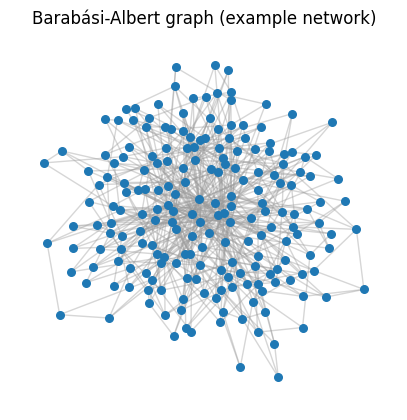

In [2]:
N = 200
m = 3

G_full = nx.barabasi_albert_graph(N, m, seed=SEED)

print(f"Number of nodes: {G_full.number_of_nodes()}")
print(f"Number of edges: {G_full.number_of_edges()}")

pos = nx.spring_layout(G_full, seed=SEED)


fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)
nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax)
nx.draw_networkx_edges(G_full, pos, alpha=0.4, edge_color='.6', ax=ax)
ax.set_axis_off()

ax.set_title("Barabási-Albert graph (example network)")

plt.show()

#### ...okay now what (your turn)

We're setting up a link prediction task using synthetic data. Where do we start?


In [3]:
pass

_______________

### Constructing a train/test split by hiding edges

To turn link prediction into a supervised learning problem, we need examples of node pairs that *do* become edges and node pairs that *do not*. In truly temporal data we would use two snapshots, $G(t_0)$ and $G(t_1)$, and define positives as edges that appear between $t_0$ and $t_1$. In this chapter, however, we approximate this setting by **hiding** a random subset of edges from a single static graph.

The basic idea is:
1. Start from the original graph $G = (V, E)$.
2. Randomly select a fraction of existing edges to hold out as a **test set**, $E_{\text{test}} \subset E$.
3. Remove these edges from the graph to obtain a **training graph**, $ G_{\text{train}} = (V, E_{\text{train}})$ with $ E_{\text{train}} = E \setminus E_{\text{test}} $
4. Treat each $(i, j) \in E_{\text{test}}$ as a *positive* example for evaluation.
5. Sample an equal number of node pairs that are non-edges in the original graph as *negative* examples.

All link prediction scores in this chapter will be computed on $G_{\text{train}}$. 

**The evaluation task is then: using only $G_{\text{train}}$, assign higher scores to the hidden edges in $E_{\text{test}}$ than to the sampled non-edges.**

**Note:** One subtlety is connectivity. If we remove edges arbitrarily, we may disconnect $G_{\text{train}}$ in ways that make the task less realistic or break methods that assume a single connected component. To avoid this, our splitting function can optionally avoid removing bridges (aka edges whose removal would disconnect the graph). When `ensure_connected=True`, we only hide non-bridge edges, so that $G_{\text{train}}$ remains connected.




The helper function below wraps all of this into a single call:

- Input: an undirected simple graph `G`, a test fraction, and a random seed.
- Output:
  - `G_train`: the training graph with some edges removed,
  - `test_edges`: the list of hidden edges (positives),
  - `test_non_edges`: a sampled list of non-edges (negatives) of the same size.

We will reuse this function throughout the chapter to generate consistent train/test splits for different graphs and methods.


In [4]:
def train_test_split_graph(G, test_frac=0.2, seed=5, ensure_connected=True):
    """
    Create a train/test split of edges for link prediction.

    Parameters
    ----------
    G : nx.Graph
        Original undirected graph (assumed simple).
    test_frac : float
        Target fraction of edges to hide for testing (between 0 and 1).
    seed : int
        Random seed for reproducibility.
    ensure_connected : bool
        If True, avoid removing edges that would disconnect the training graph.
        If there are not enough non-bridge edges, fewer than test_frac * |E|
        edges will be removed.

    Returns
    -------
    G_train : nx.Graph
        Training graph with some edges removed.
    test_edges : list of (i, j)
        Edges that were removed and will be used as positive test examples.
    test_non_edges : list of (i, j)
        Node pairs that are not edges in the original graph, used as
        negative examples.
    """
    rng_local = np.random.default_rng(seed)

    # Work on a copy so we never mutate the original input graph
    G_train = G.copy()
    all_edges = list(G_train.edges())
    n_edges = len(all_edges)

    # Number of edges we will try to hide (may be fewer if we run out
    # of non-bridge edges when ensure_connected=True)
    n_test = int(test_frac * n_edges)

    # Randomize edge order so the choice of hidden edges is uniform-ish
    rng_local.shuffle(all_edges)
    test_edges = []

    if ensure_connected:
        # Remove edges one by one, skipping bridges to keep G_train connected
        for (i, j) in all_edges:
            if len(test_edges) >= n_test:
                break

            # Bridges change as we remove edges, so we recompute them each time
            # (fine for small/medium graphs; this is a teaching function)
            bridges = set(nx.bridges(G_train)) if nx.has_bridges(G_train) else set()

            # If this edge is currently a bridge, skip it to avoid disconnecting
            if (i, j) in bridges or (j, i) in bridges:
                continue

            # Otherwise, remove the edge and record it as a positive test example
            G_train.remove_edge(i, j)
            test_edges.append((i, j))
        # Note: if there are not enough non-bridge edges, test_edges may end up
        # shorter than n_test; we handle that naturally below.
    else:
        # Simple random edge hold-out: remove the first n_test shuffled edges
        test_edges = all_edges[:n_test]
        G_train.remove_edges_from(test_edges)

    # Sample negative examples (non-edges) from the *original* graph G.
    # Using G (not G_train) guarantees we never accidentally choose a hidden
    # positive edge as a "negative" example.
    non_edges = list(nx.non_edges(G))
    rng_local.shuffle(non_edges)

    # Take as many negatives as there are positives, so the test set is balanced
    test_non_edges = non_edges[: len(test_edges)]

    return G_train, test_edges, test_non_edges


In [5]:
G_train, test_edges, test_non_edges = train_test_split_graph(G_full, test_frac=0.2,
                                                             seed=SEED, ensure_connected=True)

print(f"Original graph edges: {G_full.number_of_edges()}")
print(f"Training graph edges: {G_train.number_of_edges()}")
print(f"Number of positive test edges: {len(test_edges)}")
print(f"Number of negative test non-edges: {len(test_non_edges)}")
print(f"Is G_train connected? {nx.is_connected(G_train)}")

Original graph edges: 591
Training graph edges: 473
Number of positive test edges: 118
Number of negative test non-edges: 118
Is G_train connected? True


In [6]:
non_G_plotting = nx.Graph()
non_G_plotting.add_nodes_from(G_full.nodes())
non_G_plotting.add_edges_from(test_non_edges)

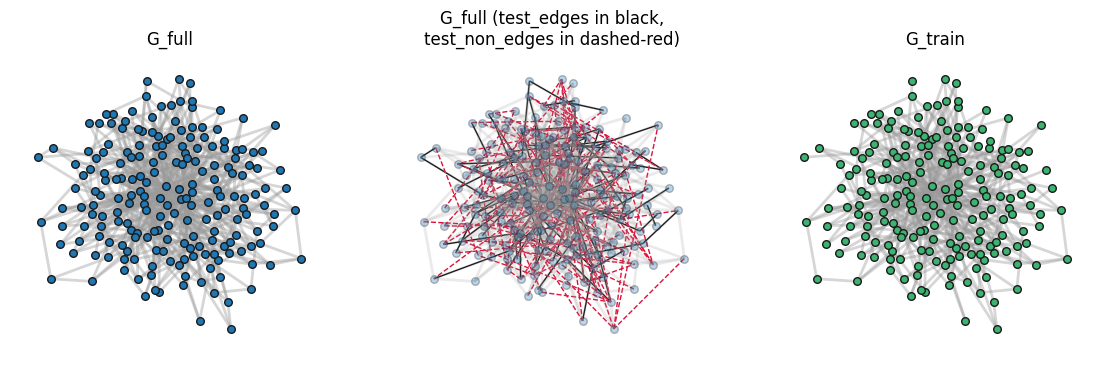

In [7]:
fig, ax = plt.subplots(1,3,figsize=(14,4),dpi=100)

nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax[0], edgecolors='.1')
nx.draw_networkx_edges(G_full, pos, alpha=0.4, edge_color='.6', ax=ax[0], width=2)
ax[0].set_axis_off()
ax[0].set_title("G_full")

nx.draw_networkx_edges(G_full, pos, edgelist=test_edges, edge_color='k', ax=ax[1], width=1)
nx.draw_networkx_edges(non_G_plotting, pos, edgelist=test_non_edges,
                       edge_color='crimson', ax=ax[1], width=1, style='--')
nx.draw_networkx_nodes(G_full, pos, node_size=30, ax=ax[1], alpha=0.3, edgecolors='.1')
nx.draw_networkx_edges(G_full, pos, alpha=0.2, edge_color='.6', ax=ax[1], width=2)
ax[1].set_axis_off()
ax[1].set_title("G_full (test_edges in black,\ntest_non_edges in dashed-red)")


nx.draw_networkx_nodes(G_train, pos, node_size=30, node_color='mediumseagreen', edgecolors='.1', ax=ax[2])
nx.draw_networkx_edges(G_train, pos, alpha=0.4, edge_color='.6', ax=ax[2], width=2)
ax[2].set_axis_off()
ax[2].set_title("G_train")



plt.show()

### Other practical considerations in constructing link prediction datasets

Our simple setup—randomly hiding a fraction of edges and sampling an equal number of non-edges—captures the basic structure of a link prediction task, but real applications introduce several subtleties:

1. **Temporal vs random splits.**
   Here we pretend that $G_{\text{full}}$ is a snapshot at time $t$ and we randomly remove edges to simulate "future" links. In genuinely temporal data, we would instead:

   * take an earlier snapshot $G(t_0)$ as the training graph,
   * define positives as new edges that appear by $t_1 > t_0$ but were absent at $t_0$,
   * sample negatives from pairs that remain non-edges at $t_1$.
     Random removal is pedagogically useful but can overestimate performance compared to truly time-respecting splits.

2. **Class imbalance and negative sampling.**
   In a graph with $n$ nodes and $m$ edges, the number of non-edges is on the order of $n^2$, while the number of positives is only $m$. Future links are rare. For computational reasons, we typically *subsample negatives rather than consider all non-edges*, and we often construct balanced datasets (as we did above) for clarity.

3. **Candidate set restrictions.**
   Many methods implicitly assume that new edges tend to close triangles. A common evaluation variant restricts candidates to node pairs at distance two in $G_{\text{train}}$, i.e., pairs that already share at least one neighbor. This focuses attention on "plausible" links and avoids rewarding trivial behavior on pairs that are far apart.

4. **Transductive vs inductive prediction.**
   In this chapter we only predict links between nodes that already exist in $G_{\text{train}}$ (transductive). In some applications (for example, recommending items to a new user), we must predict edges incident to nodes that did not exist at training time (inductive), which typically requires node attributes or more flexible models.

These details matter whenever we compare methods across datasets or claim that one algorithm outperforms another (see, e.g., the survey by [Lü and Zhou, 2011](https://www.sciencedirect.com/science/article/pii/S037843711000991X)).
__________

## Extended note: Class imbalance in link prediction

A structural feature of link prediction problems is that they are **extremely imbalanced**. In a simple undirected graph with $n$ nodes, there are

$$
\binom{n}{2} = \frac{n(n-1)}{2}
$$

possible node pairs. Only $m$ of these pairs are observed edges; the rest are non-edges. In most real networks $m \ll \binom{n}{2}$, so the fraction of pairs that are connected is tiny.

For example, if $n = 10^5$ and $m = 10^6$, then:

* the number of possible pairs is on the order of $10^{10}$,
* the edge density $m / \binom{n}{2}$ is on the order of $10^{-4}$,
* for every positive (an actual or future edge) there are tens of thousands of negatives (pairs that never connect).

This class imbalance shapes both how we construct datasets and how we interpret evaluation metrics.



### Why we artificially balance positives and negatives

In the experiments below, we created balanced test sets by:

* hiding a subset of edges as positives (for example, $|E_{\text{test}}|$ edges), and
* sampling an equal number of non-edges as negatives.

This artificial balancing is useful for teaching and small-scale experiments:

1. It keeps the dataset size manageable: we do not need to score all $O(n^2)$ non-edges.
2. It avoids trivial baselines that achieve nearly perfect accuracy by predicting "no edge" almost everywhere.
3. It makes metrics like ROC-AUC and precision@$k$ easier to interpret numerically.

However, it also means that our reported numbers do not directly reflect performance on the full, highly imbalanced space of all candidate pairs.

### Why *accuracy* is misleading

Consider a classifier that predicts "no link" for every candidate pair: if we evaluate it on all pairs $(i,j)$, its accuracy is extremely high (close to 1), because almost all pairs are non-edges... but it is useless for link prediction, because it never finds any new edges.

Even on balanced test sets, accuracy can be a weak indicator of ranking quality. This is why link prediction work typically reports ranking metrics (ROC-AUC, precision@$k$, average precision) rather than raw accuracy. More on this sooon!

Because we rarely evaluate on all non-edges, we must decide which *negatives to sample*. Different choices answer different questions:

* Uniform negative sampling asks whether the method can separate future edges from "typical" non-edges.
* Distance-restricted sampling focuses on deciding which open triads will close.
* Popularity- or exposure-aware sampling is common in recommendation systems, where not all non-edges are equally "negative".

The final numerical value of ROC-AUC or precision@$k$ should always be interpreted relative to how the negative examples were constructed.
_____________

## Let's predict some missing links!
... okay, how?

### Classical neighborhood-based link prediction scores

A large body of work on link prediction starts from a simple, intuitive idea:

> Two nodes are more likely to form a link if they have many neighbors in common or if they are embedded in similar local neighborhoods.

In social networks, this is the notion of *triadic closure* (i.e., the "friends of my friends are likely to become my friends.") In other domains, it corresponds to functional similarity (two neurons that interact with many of the same partners may be part of the same cluster) or topical relatedness (two web pages that are connected by many others may cover similar content).

For an undirected graph, let $\Gamma(i)$ denote the set of neighbors of node $i$, and let $k_i = |\Gamma(i)|$ be its degree. The simplest neighborhood-based link prediction scores are functions of overlaps between $\Gamma(i)$ and $\Gamma(j)$ and the degrees of $i$, $j$, and their common neighbors. **THERE ARE SO MANY LINK PREDICTION ALGORITHMS,** but let's focus on a couple canonical ones here.



1. **Common neighbors (CN)**
    The most direct measure simply counts how many neighbors $i$ and $j$ share:

    $$
    s_{\text{CN}}(i, j) = |\Gamma(i) \cap \Gamma(j)|
    $$
    
    This implements the pure triadic-closure intuition: the more common neighbors two nodes have, the more opportunities there have been for a link to form between them. In early empirical work on social and information networks, Liben-Nowell and Kleinberg (2007) found that common neighbors alone can already perform surprisingly well.



2. **Jaccard coefficient**
    Common neighbors can be biased toward high-degree nodes: two hubs may share many neighbors simply because they each have many neighbors. The **Jaccard coefficient** normalizes by the size of the union:

    $$
    s_{\text{Jaccard}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{|\Gamma(i) \cup \Gamma(j)|}
    $$
    
    This is identical to the Jaccard similarity from information retrieval, applied to neighbor sets. It assigns a high score only when the shared neighbors form a large *fraction* of the nodes' combined neighborhoods, not just a large absolute count.




3. **Adamic-Adar index (AA)**
   The **Adamic-Adar index** (Adamic and Adar, 2003) refines common neighbors by downweighting common neighbors that are themselves very high-degree hubs:
   $$
   s_{\text{AA}}(i, j)
   = \sum_{l \in \Gamma(i) \cap \Gamma(j)} \frac{1}{\log k_l}
   $$
   The idea is that a common neighbor $l$ that is connected to *everyone* carries less specific information about similarity between $i$ and $j$ than a rare, low-degree neighbor. The logarithm in the denominator means that the penalty grows slowly with degree: very large degrees are heavily discounted, but modest differences among low-degree nodes still matter.




4. **Preferential attachment (PA)**
    The **preferential attachment** score uses only the degrees of $i$ and $j$:
    
    $$
    s_{\text{PA}}(i, j) = k_i,k_j
    $$
    
    This is motivated by preferential-attachment network models, in which new nodes attach to existing nodes with probability proportional to degree (Albert and Barabási, 2002). In such models, high-degree nodes tend to gain new neighbors more quickly, and pairs of hubs are especially likely to connect. Unlike the previous scores, PA does *not* look at common neighbors at all; it purely encodes the rich-getting-richer effect.




5. **Resource allocation index (RA)**
    The **resource allocation** index (Zhou, Lü, and Zhang, 2009) is similar in spirit to Adamic-Adar but uses a $1/k_l$ penalty instead of $1/\log k_l$:

    $$
    s_{\text{RA}}(i, j)
    = \sum_{l \in \Gamma(i) \cap \Gamma(j)} \frac{1}{k_l}
    $$
    
    This can be interpreted as a simple diffusion or resource-sharing process: imagine each common neighbor $l$ has one unit of "resource" and distributes it equally among its neighbors. The amount of resource that flows from $i$ to $j$ via $l$ is then $1/k_l$. Summing over all common neighbors measures how much resource $i$ could send to $j$ through paths of length two. Compared to Adamic-Adar, the $1/k_l$ penalty is stronger for high-degree nodes, so RA tends to emphasize rare, low-degree common neighbors even more.




All five scores are **local**: they depend only on the immediate neighborhoods of $i$ and $j$, and they assign higher scores to node pairs that are structurally similar in a first-order sense. They are symmetric in $i$ and $j$, and they can be computed for any non-edge $(i,j)$ without fitting a global model.

Despite their simplicity, these scores serve as strong, interpretable baselines in many applications, and they often perform competitively with more complex methods on social and information networks (Liben-Nowell and Kleinberg, 2007; Adamic and Adar, 2003; Lü and Zhou, 2011; Zhou, Lü, and Zhang, 2009). In the next section, we will implement each of them in `networkx` and compare their performance on synthetic and empirical graphs.

### Your turn!

We need functions for five link prediction algorithms:

```
1. common_neighbors_score
2. jaccard_score
3. adamic_adar_score
4. preferential_attachment_score
5. resource_allocation_score
```


In [8]:
def common_neighbors_score(G, i, j):
    """
    Compute the common-neighbors score between nodes i and j.

    s_CN(i, j) = |Γ(i) ∩ Γ(j)|

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Common-neighbors score between i and j.
    """
    # TODO:
    # 1. Get the neighbor sets of i and j.
    # 2. Compute the size of their intersection.
    # 3. Return that value as a float.

    pass

In [9]:
def jaccard_score(G, i, j):
    """
    Compute the Jaccard coefficient between nodes i and j.

    s_Jaccard(i, j) = |Γ(i) ∩ Γ(j)| / |Γ(i) ∪ Γ(j)|

    If both nodes have no neighbors (empty union), define the score to be 0.0.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Jaccard similarity between the neighbor sets of i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) as Python sets.
    # 2. Compute the intersection and union of these sets.
    # 3. If the union is empty, return 0.0.
    # 4. Otherwise, return |intersection| / |union| as a float.
    
    pass

In [10]:
def adamic_adar_score(G, i, j):
    """
    Compute the Adamic-Adar index between nodes i and j.

    s_AA(i, j) = sum_{w in Γ(i) ∩ Γ(j)} 1 / log(k_w)

    where k_w is the degree of the common neighbor w. You may skip or
    ignore terms where k_w <= 1 to avoid division by zero.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Adamic-Adar score between i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) and compute their intersection (common neighbors).
    # 2. For each common neighbor w:
    #       - Compute its degree k_w.
    #       - Add 1 / log(k_w) to a running sum (when k_w > 1).
    # 3. Return the final sum as a float.
    
    pass

In [11]:
def preferential_attachment_score(G, i, j):
    """
    Compute the preferential-attachment score between nodes i and j.

    s_PA(i, j) = k_u * k_v

    where k_u and k_v are the degrees of i and j.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Preferential-attachment score between i and j.
    """
    # TODO:
    # 1. Get the degrees of i and j from G.
    # 2. Return their product as a float.
    
    pass

In [12]:
def resource_allocation_score(G, i, j):
    """
    Compute the resource allocation index between nodes i and j.

    s_RA(i, j) = sum_{w in Γ(i) ∩ Γ(j)} 1 / k_w

    where k_w is the degree of the common neighbor w.

    Parameters
    ----------
    G : nx.Graph
        Undirected simple graph.
    i, j : int
        Node identifiers.

    Returns
    -------
    float
        Resource-allocation score between i and j.
    """
    # TODO:
    # 1. Get Γ(i) and Γ(j) and compute their intersection (common neighbors).
    # 2. For each common neighbor w:
    #       - Compute its degree k_w.
    #       - Add 1 / k_w to a running sum (when k_w > 0).
    # 3. Return the final sum as a float.
    
    pass

In [13]:
pass

Don't look below!
_____________

In [14]:
def common_neighbors_score(G, i, j):
    """
    Compute the common-neighbors score between nodes i and j.

    s_CN(i, j) = |Γ(i) ∩ Γ(j)|,

    where Γ(i) is the set of neighbors of i.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Number of common neighbors between i and j.
    """
    # Neighbor sets of each node
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))

    # Intersection of neighbor sets
    common = neighbors_i & neighbors_j

    return float(len(common))


def jaccard_score(G, i, j):
    """
    Compute the Jaccard coefficient between nodes i and j.

    s_Jaccard(i, j) = |Γ(i) ∩ Γ(j)| / |Γ(i) ∪ Γ(j)|.

    If both nodes have no neighbors (empty union), the score is defined as 0.0.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Jaccard similarity between the neighbor sets of i and j.
    """
    # Neighbor sets of each node
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))

    # Intersection and union of neighbor sets
    intersection = neighbors_i & neighbors_j
    union = neighbors_i | neighbors_j

    # If both nodes are isolated, define similarity to be 0
    if not union:
        return 0.0

    return len(intersection) / len(union)


def adamic_adar_score(G, i, j):
    """
    Compute the Adamic-Adar index between nodes i and j.

    s_AA(i, j) = sum_{l in Γ(i) ∩ Γ(j)} 1 / log(k_l),

    where k_l is the degree of the common neighbor l.
    Terms with k_l <= 1 are skipped to avoid log(1) = 0 and log(0) issues.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Adamic-Adar score between i and j.
    """
    # Neighbor sets and common neighbors
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))
    common_neighbors = neighbors_i & neighbors_j

    score = 0.0

    # Accumulate 1 / log(k_l) across common neighbors
    for ell in common_neighbors:
        k_ell = G.degree[ell]
        # Skip degree 0 or 1 to avoid log(0) or division by zero
        if k_ell > 1:
            score += 1.0 / np.log(k_ell)

    return score


def preferential_attachment_score(G, i, j):
    """
    Compute the preferential-attachment score between nodes i and j.

    s_PA(i, j) = k_i * k_j,

    where k_i and k_j are the degrees of i and j.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Preferential-attachment score between i and j.
    """
    k_i = G.degree[i]
    k_j = G.degree[j]

    return float(k_i * k_j)


def resource_allocation_score(G, i, j):
    """
    Compute the resource allocation (RA) index between nodes i and j.

    s_RA(i, j) = sum_{l in Γ(i) ∩ Γ(j)} 1 / k_l,

    where k_l is the degree of the common neighbor l.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.
    i, j
        Node identifiers.

    Returns
    -------
    float
        Resource-allocation score between i and j.
    """
    # Neighbor sets and common neighbors
    neighbors_i = set(G.neighbors(i))
    neighbors_j = set(G.neighbors(j))
    common_neighbors = neighbors_i & neighbors_j

    score = 0.0

    # Accumulate 1 / k_l across common neighbors
    for ell in common_neighbors:
        k_ell = G.degree[ell]
        if k_ell > 0:
            score += 1.0 / k_ell

    return score


_______

#### What do these scores even look like?
Let's start by looking at the scores for the postitive edges, starting with Jaccard...

In [15]:
pos_scores_jac = [jaccard_score(G_train, i, j) for (i, j) in test_edges]

In [16]:
neg_scores_jac = [jaccard_score(G_train, i, j) for (i, j) in test_non_edges]

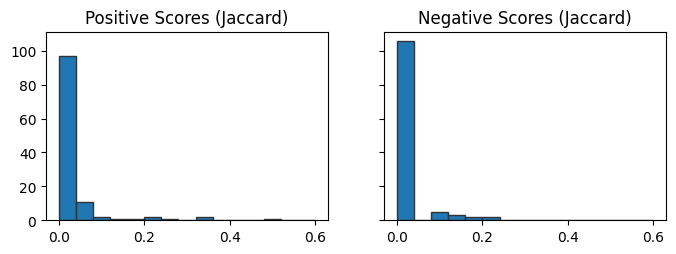

In [17]:
fig, ax = plt.subplots(1,2,figsize=(8,2.5),dpi=100,sharex=True,sharey=True)

ax[0].hist(pos_scores_jac,bins=np.linspace(0,0.6,16),ec='.2')
ax[1].hist(neg_scores_jac,bins=np.linspace(0,0.6,16),ec='.2')

ax[0].set_title('Positive Scores (Jaccard)')
ax[1].set_title('Negative Scores (Jaccard)')

plt.show()

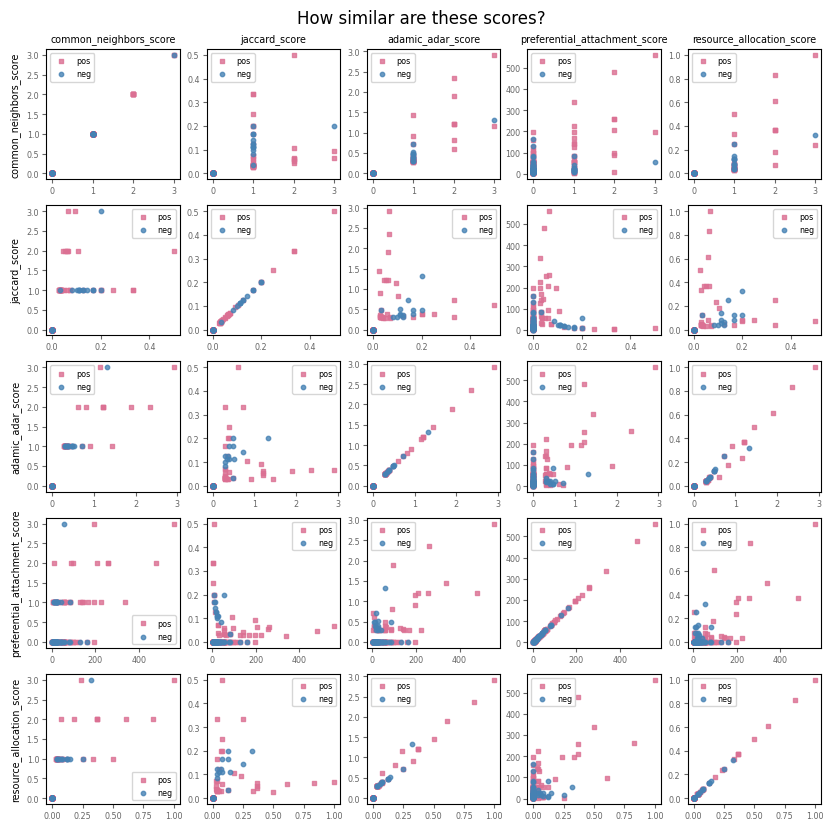

In [18]:
fig, ax = plt.subplots(5,5,figsize=(10,10),dpi=100)

labels = ['common_neighbors_score', 'jaccard_score', 'adamic_adar_score',
          'preferential_attachment_score', 'resource_allocation_score']
for i1, func1 in enumerate([common_neighbors_score, jaccard_score, adamic_adar_score,
                           preferential_attachment_score, resource_allocation_score]):
    
    pos_scores1 = [func1(G_train, i, j) for (i, j) in test_edges]
    neg_scores1 = [func1(G_train, i, j) for (i, j) in test_non_edges]

    for i2, func2 in enumerate([common_neighbors_score, jaccard_score, adamic_adar_score,
                               preferential_attachment_score, resource_allocation_score]):

        pos_scores2 = [func2(G_train, i, j) for (i, j) in test_edges]
        neg_scores2 = [func2(G_train, i, j) for (i, j) in test_non_edges]
        
        
        ax[i1,i2].scatter(pos_scores1, pos_scores2, s=10, marker='s',
                          c='palevioletred', label='pos', alpha=0.8)
        ax[i1,i2].scatter(neg_scores1, neg_scores2, s=10, marker='o',
                          c='steelblue', label='neg', alpha=0.8)
        
        if i1==0:
            ax[i1,i2].set_title(labels[i2],fontsize='x-small')

        if i2==0:
            ax[i1,i2].set_ylabel(labels[i1],fontsize='x-small')
            
        ax[i1,i2].tick_params(which='both', length=3, pad=2, labelsize='xx-small',
                              labelcolor='.4', color='.4')
        ax[i1,i2].legend(fontsize='xx-small')


plt.suptitle('How similar are these scores?', y=0.92)

plt.show()

### Evaluating a scoring function

Once we define a link-prediction score $s(i, j)$, we need a way to quantify how well it separates true future edges from non-edges. Given a training graph $G_{\text{train}}$, a set of hidden **positive** edges (the test edges), and a set of sampled **negative** pairs (non-edges), we can:

1. compute a score for each positive and negative example using our chosen function `score_fn(G, i, j)`,
2. build a label vector with 1 for positives and 0 for negatives,
3. compare the resulting scores and labels using the ROC-AUC metric.

The helper function below wraps this pattern: it takes a training graph, lists of positive and negative pairs, and a scoring function, and returns the labels, the scores, and the ROC-AUC value (optionally printing it as well). We will reuse this for all of the neighborhood-based scores in this chapter.



#### Evaluation Technique: ROC-AUC 

Given a score function $s(i, j)$, we can evaluate it on our labeled examples:

* For each positive test edge $(i, j) \in E_{\text{test}}$, compute its score.
* For each negative test pair $(i, j) \in \mathcal{N}_{\text{test}}$ (sampled non-edges), compute its score.

Ideally, the scores for positive examples are stochastically larger than those for negative examples.

One standard metric is the area under the receiver-operating characteristic curve (ROC-AUC). The ROC curve traces the trade-off between true positive rate and false positive rate as we vary the threshold on $s(i, j)$. The AUC has a useful interpretation:

> The AUC is the probability that a randomly chosen positive example receives a higher score than a randomly chosen negative example.

An AUC of $0.5$ corresponds to random guessing; an AUC of $1.0$ is perfect ranking.

__________

In [19]:
def evaluate_score_function(G_train, test_edges, test_non_edges, score_fn, verbose=True):
    """
    Evaluate a link-prediction scoring function using ROC-AUC.

    Parameters
    ----------
    G_train : networkx.Graph
        Training graph used to compute scores.
    test_edges : list of (i, j)
        Positive examples (edges that were removed from the original graph).
    test_non_edges : list of (i, j)
        Negative examples (node pairs that are non-edges in the original graph).
    score_fn : callable
        Function of the form score_fn(G, i, j) -> float.
    verbose : bool, optional
        If True, print the AUC value.

    Returns
    -------
    y_true : numpy.ndarray
        True labels (1 for positive edges, 0 for non-edges).
    y_scores : numpy.ndarray
        Scores assigned by score_fn to each example.
    auc : float
        ROC-AUC value.
    """
    # Scores for positive examples
    pos_scores = [score_fn(G_train, i, j) for (i, j) in test_edges]

    # Scores for negative examples
    neg_scores = [score_fn(G_train, i, j) for (i, j) in test_non_edges]

    # True labels: 1 for positives, 0 for negatives
    y_true = np.array([1] * len(pos_scores) + [0] * len(neg_scores))

    # Concatenate scores in the same order as labels
    y_scores = np.array(pos_scores + neg_scores)

    # Compute ROC-AUC
    auc = roc_auc_score(y_true, y_scores)

    if verbose:
        print(f"AUC = {auc:.3f}")

    return y_true, y_scores, auc


In [20]:
print("BA graph: Common neighbors:")
y_cn, scores_cn, auc_cn = evaluate_score_function(
    G_train, test_edges, test_non_edges, common_neighbors_score
)
print()
print("BA graph: Jaccard:")
y_jac, scores_jac, auc_jac = evaluate_score_function(
    G_train, test_edges, test_non_edges, jaccard_score
)

print()
print("BA graph: Adamic-Adar:")
y_aa, scores_aa, auc_aa = evaluate_score_function(
    G_train, test_edges, test_non_edges, adamic_adar_score
)

print()
print("BA graph: Preferential attachment:")
y_pa, scores_pa, auc_pa = evaluate_score_function(
    G_train, test_edges, test_non_edges, preferential_attachment_score
)

print()
print("BA graph: Resource allocation:")
y_ra, scores_ra, auc_ra = evaluate_score_function(
    G_train, test_edges, test_non_edges, resource_allocation_score
)


BA graph: Common neighbors:
AUC = 0.596

BA graph: Jaccard:
AUC = 0.585

BA graph: Adamic-Adar:
AUC = 0.592

BA graph: Preferential attachment:
AUC = 0.673

BA graph: Resource allocation:
AUC = 0.592


### Visualizing performance: ROC curves

Numerical AUC values are compact but opaque. It is often helpful to visualize the ROC curves for several methods on the same plot. This can reveal, for example, that two methods have similar AUC but behave differently at low false positive rates.

In settings like recommendation, we often care most about the left part of the ROC curve: how many true positives we can recover before we start incurring many false positives.


In [21]:
score_dict = {
    "Common neighbors": scores_cn,
    "Jaccard": scores_jac,
    "Adamic-Adar": scores_aa,
    "Preferential attachment": scores_pa,
    "Resource allocation": scores_ra,
}

In [22]:
y_true = y_cn.copy()

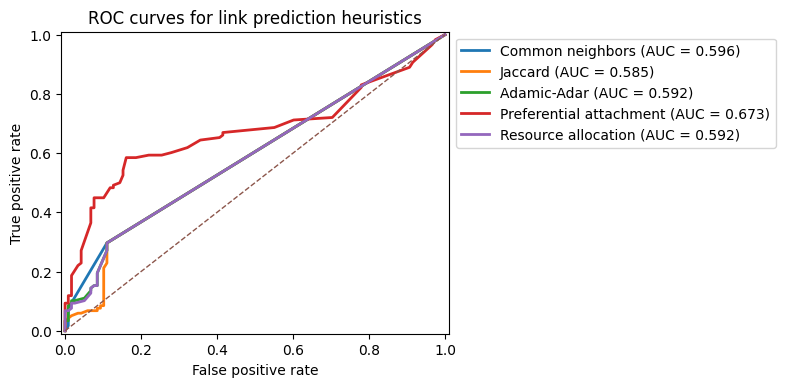

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5, 4), dpi=100)

for name, scores in score_dict.items():
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", lw=2)

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves for link prediction heuristics")
ax.legend(bbox_to_anchor=[1.0,1.0],loc=2)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

__________
### Other structural link prediction scores

The heuristics above are part of a larger family of structurally defined similarity measures (Liben-Nowell and Kleinberg, 2007; Lü and Zhou, 2011), including:

* **Salton index (cosine similarity):**

    $$
    s_{\text{Salton}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\sqrt{k_i,k_j}}
    $$

* **Sørensen index:**

    $$
    s_{\text{Sørensen}}(i, j)
    = \frac{2,|\Gamma(i) \cap \Gamma(j)|}{k_i + k_j}
    $$

* **Hub-promoted and hub-depressed indices:**

    $$
    s_{\text{HPI}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\min{k_i, k_j}} ,
    \qquad
    s_{\text{HDI}}(i, j)
    = \frac{|\Gamma(i) \cap \Gamma(j)|}{\max{k_i, k_j}}
    $$

Most of these differ only in how they normalize the common-neighbors count. Empirically, several of them achieve similar performance on social and information networks, and Common Neighbors, Jaccard, Adamic-Adar, and Resource Allocation often serve as representative baselines.


### Global similarity measures

The heuristics above depend only on the immediate neighborhoods of $i$ and $j$. One can also define **global** similarity measures that take into account paths of all lengths in the network. A classical example is the Katz index (Katz, 1953). Let $A$ be the adjacency matrix of $G$. For nodes $i$ and $j$, the Katz similarity is

$$
s_{\text{Katz}}(i, j)
= \sum_{l = 1}^{\infty} \beta^l \big[A^l\big]*{ij}
$$

where $\beta > 0$ is a decay parameter and $\big[A^l\big]*{ij}$ counts the number of walks of length $l$ from $i$ to $j$. Short walks contribute more than long walks, and all walks are downweighted by $\beta^l$. In practice one truncates this series at some maximum length or uses matrix methods to approximate it.

Random-walk-based scores, such as those derived from personalized PageRank or commute times, follow a similar spirit: they use properties of random walks on the graph to quantify how easily information can flow between two nodes. These global measures are more computationally demanding than local heuristics but can capture long-range structural information that local measures miss.
__________

## Ranking quality and precision at top-$k$

In many applications, we are not forced to classify all candidate pairs. Instead, we only act on the highest-scoring predictions, such as:

* recommending the top 10 new friends to each user,
* suggesting the top 50 potential collaboration links,
* prioritizing the top 100 candidate interactions for experimental validation.

In these scenarios, **precision at top-$k$** is often more meaningful than AUC. For a given $k$:

1. Sort all candidate pairs by their scores in descending order.
2. Take the top $k$ pairs.
3. Compute... $ \text{Precision@}k = \frac{\text{number of true edges among the top } k \text{ pairs}}{k} $

High precision at small $k$ indicates that the method is very good at identifying the most promising candidates.

In [24]:
def precision_at_k(y_true, y_scores, k):
    """
    Compute precision at top-k.

    Parameters
    ----------
    y_true : array-like
        True labels (1 for positive, 0 for negative).
    y_scores : array-like
        Scores for each example (higher means more likely positive).
    k : int
        Number of top predictions to consider.

    Returns
    -------
    float
        Fraction of the top-k scored examples that are actually positive.
    """
    if k <= 0:
        raise ValueError("k must be positive")

    # Do not ask for more than we have
    k = min(k, len(y_true))

    # Indices of examples sorted by score in descending order
    idx_sorted = np.argsort(-y_scores)

    # Take the top-k indices and compute the fraction that are positive
    topk_idx = idx_sorted[:k]

    return y_true[topk_idx].sum() / k

In [25]:
ks = [5, 10, 20, 50]

methods = {
    "Common neighbors": (y_cn, scores_cn),
    "Jaccard": (y_jac, scores_jac),
    "Adamic-Adar": (y_aa, scores_aa),
    "Preferential attachment": (y_pa, scores_pa),
    "Resource allocation": (y_ra, scores_ra),
}

for name, (y, scores) in methods.items():
    print(f"\n{name}:")
    for k in ks:
        p_at_k = precision_at_k(y, scores, k)
        print(f"  Precision@{k:2d} = {p_at_k:.3f}")



Common neighbors:
  Precision@ 5 = 0.800
  Precision@10 = 0.900
  Precision@20 = 0.950
  Precision@50 = 0.700

Jaccard:
  Precision@ 5 = 1.000
  Precision@10 = 0.600
  Precision@20 = 0.450
  Precision@50 = 0.700

Adamic-Adar:
  Precision@ 5 = 0.800
  Precision@10 = 0.900
  Precision@20 = 0.700
  Precision@50 = 0.700

Preferential attachment:
  Precision@ 5 = 1.000
  Precision@10 = 1.000
  Precision@20 = 0.900
  Precision@50 = 0.840

Resource allocation:
  Precision@ 5 = 1.000
  Precision@10 = 0.800
  Precision@20 = 0.650
  Precision@50 = 0.700


### Even more ways to measuring performance...

- **Accuracy**  --- Fraction of correct predictions.  

    $$
    \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}
    $$

- **Precision**  --- Fraction of true positive predictions among all positive predictions.  

    $$
    \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
    $$

- **Recall** --- Fraction of true positives identified among all actual positives (also called sensitivity).  
        
    $$
    \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
    $$

- **F1-Score**  --- Harmonic mean of Precision and Recall, balancing the two metrics.  

    $$
    F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
    $$

- **AUC-ROC** (Area Under the Receiver Operating Characteristic Curve) --- Evaluates a classifier's ability to discriminate between classes. It measures the area under the curve plotted between True Positive Rate (TPR) and False Positive Rate (FPR) at different thresholds:  

    $$
    \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
    $$

- **AUC-PR** (Area Under the Precision-Recall Curve) --- 
    Evaluates the trade-off between Precision and Recall across thresholds, useful for imbalanced datasets.


____________
### ...and even *more* (based on ranking)
Goal: evaluate the quality of *rankings* generated by the algorithm, how well the algorithm ranks true edges against false ones. MRR (mean reciprocal rank), Hit Rate, Kendall's Tau, MAP (Mean Average Precision)

**Mean Reciprocal Rank (MRR)**
Measures ranking quality for link prediction tasks, focusing on how highly a **true positive** is ranked:  

$$
\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}
$$

- $ Q $: Set of queries (node pairs).
- $ \text{rank}_i $: Position of the first relevant link for the $ i $-th query.


**Hit Rate**
Measures the fraction of queries where at least **one correct link prediction appears** in the top $ k $: ( e.g. the share of users for which at least one relevant item is present in the top k.)

$$
\text{Hit Rate} = \frac{\text{Number of queries with a relevant result in top-}k}{|Q|}
$$


**Kendall's Tau**
Measures the similarity between two rankings. It is a correlation measure based on the number of concordant and discordant pairs:  

$$
\tau = \frac{C - D}{\frac{1}{2}n(n-1)}
$$

- $ C $: Number of concordant pairs.
- $ D $: Number of discordant pairs.
- $ n $: Total number of ranked pairs.


**MAP (Mean Average Precision)**
Evaluates ranking by averaging precision at each relevant item in the ranking list for all queries: (average of the precisions calculated at the ranks where the **true positive links appear** in the ranked list.)

$$
\text{MAP} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \text{AP}_i, \quad \text{AP}_i = \frac{1}{m_i} \sum_{k=1}^{m_i} P(k)
$$

- $m_i $: Number of relevant items for the $ i $-th query.
- $ P(k) $: Precision at rank $ k $.
___________

-------

## Restricting candidate pairs to distance two

So far we have sampled negative examples uniformly from all non-edges. In very sparse graphs, many of these pairs are far apart and extremely unlikely to form edges. A different evaluation protocol, common in link prediction experiments, is to restrict attention to node pairs at distance $d=2$ in $G_{\text{train}}$.

A pair $(i, j)$ is at distance two if $i$ and $j$ are not directly connected but share at least one neighbor. Restricting candidates to distance-two pairs focuses the task on deciding which open triads will close.

In [26]:
def distance_two_candidates(G):
    """
    Return all unordered node pairs (i, j) that are at distance exactly 2
    in G and are not already edges.

    Parameters
    ----------
    G : networkx.Graph
        Undirected simple graph.

    Returns
    -------
    list of (i, j)
        Node pairs with shortest-path distance 2.
    """
    pairs = set()

    for i in G.nodes():
        # Neighbors of i
        neighbors_i = set(G.neighbors(i))

        # Nodes reachable in two steps from i: neighbors-of-neighbors
        two_step = set()
        for k in neighbors_i:
            two_step.update(G.neighbors(k))

        # Remove i itself and its direct neighbors (we only want distance-2)
        two_step.discard(i)
        two_step.difference_update(neighbors_i)

        # For each candidate j at distance 2, add the unordered pair (i, j)
        for j in two_step:
            # Enforce i < j to avoid duplicates like (i, j) and (j, i)
            if i < j and not G.has_edge(i, j):
                pairs.add((i, j))

    # Return a sorted list for reproducibility
    return sorted(pairs)


In [27]:
# Build a distance-two candidate set on the BA training graph
dist2_pairs = distance_two_candidates(G_train)
len(dist2_pairs)

3339

In [28]:
# For a fair comparison, sample positives and negatives from the distance-two set

# Positives among distance-two pairs: test edges that share at least one neighbor in G_train
test_edges_dist2 = [(i, j) for (i, j) in test_edges
                    if (i, j) in dist2_pairs or (j, i) in dist2_pairs]

# Negatives: distance-two non-edges
rng_local = np.random.default_rng(SEED)
rng_local.shuffle(dist2_pairs)
neg_dist2 = dist2_pairs[: len(test_edges_dist2)]

print("Distance-two candidates:")
print("  Positives:", len(test_edges_dist2))
print("  Negatives:", len(neg_dist2))


Distance-two candidates:
  Positives: 35
  Negatives: 35


In [29]:
# Evaluate one method (e.g. Adamic-Adar) under distance-two restriction
y_aa_full, scores_aa_full, auc_aa_full = evaluate_score_function(
    G_train, test_edges, test_non_edges, adamic_adar_score, verbose=False
)
y_aa_d2, scores_aa_d2, auc_aa_d2 = evaluate_score_function(
    G_train, test_edges_dist2, neg_dist2, adamic_adar_score, verbose=False
)

print(f"Adamic-Adar AUC (uniform negatives):      {auc_aa_full:.3f}")
print(f"Adamic-Adar AUC (distance-two negatives): {auc_aa_d2:.3f}")


Adamic-Adar AUC (uniform negatives):      0.592
Adamic-Adar AUC (distance-two negatives): 0.562



AUC values typically increase when we restrict to distance-two pairs, because the task becomes "easier": many randomly chosen non-edges are far apart and trivial to reject. The distance-two evaluation is useful when we are specifically interested in triadic closure, but it answers a narrower question than the uniform-negative setting.

------

## Link prediction on a social network: the Karate Club

The Barabási-Albert graph is a stylized model with heavy-tailed degree distributions but no explicit social interpretation. To see how the same heuristics behave on a more realistic social network, we now repeat the analysis on Zachary's Karate Club network, which represents friendships among members of a university karate club. This network is small, undirected, and relatively assortative: many edges connect nodes that are already embedded in shared neighborhoods. Local similarity heuristics such as common neighbors and Adamic-Adar are often expected to perform well in this setting.

In [30]:
# Load the Karate Club network
G_karate = nx.karate_club_graph()

# Train/test split as before
G_karate_train, test_karate, neg_karate = train_test_split_graph(
    G_karate, test_frac=0.2, seed=SEED, ensure_connected=True
)

print("  Train edges:", G_karate_train.number_of_edges())
print("  Test positives:", len(test_karate))
print("  Test negatives:", len(neg_karate))

  Train edges: 63
  Test positives: 15
  Test negatives: 15


In [31]:
# Evaluate all heuristics on the Karate network
karate_results = {}
for name, fn in [
    ("Common neighbors", common_neighbors_score),
    ("Jaccard", jaccard_score),
    ("Adamic-Adar", adamic_adar_score),
    ("Preferential attachment", preferential_attachment_score),
    ("Resource allocation", resource_allocation_score),
]:
    y, scores, auc = evaluate_score_function(
        G_karate_train, test_karate, neg_karate, fn, verbose=False
    )
    karate_results[name] = (y, scores, auc)

for name, (y, scores, auc) in karate_results.items():
    print(f"{name:23s}: ROC-AUC = {auc:.3f}")


Common neighbors       : ROC-AUC = 0.689
Jaccard                : ROC-AUC = 0.602
Adamic-Adar            : ROC-AUC = 0.707
Preferential attachment: ROC-AUC = 0.738
Resource allocation    : ROC-AUC = 0.711


In [32]:
# Plot ROC curves for the Karate Club network
score_dict_karate = {name: vals[1] for name, vals in karate_results.items()}
y_karate = next(iter(karate_results.values()))[0]  # all y's are identical

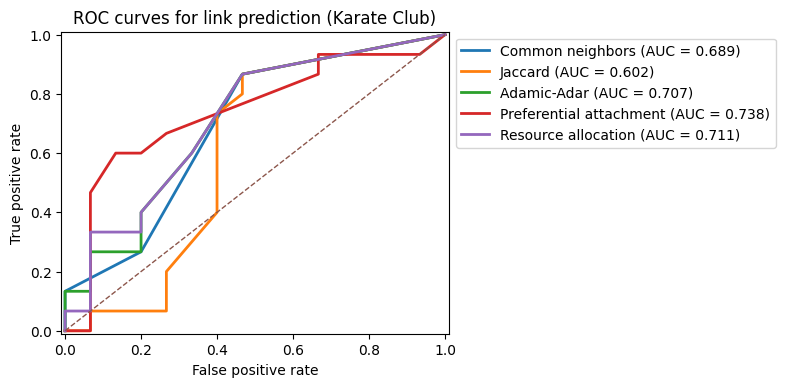

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5, 4), dpi=100)

for name, scores in score_dict_karate.items():
    fpr, tpr, _ = roc_curve(y_karate, scores)
    auc = roc_auc_score(y_karate, scores)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", lw=2)

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves for link prediction (Karate Club)")
ax.legend(bbox_to_anchor=[1.0,1.0],loc=2)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

### Your turn! Visualize the top 10 highest-score edges from each method in the plot below

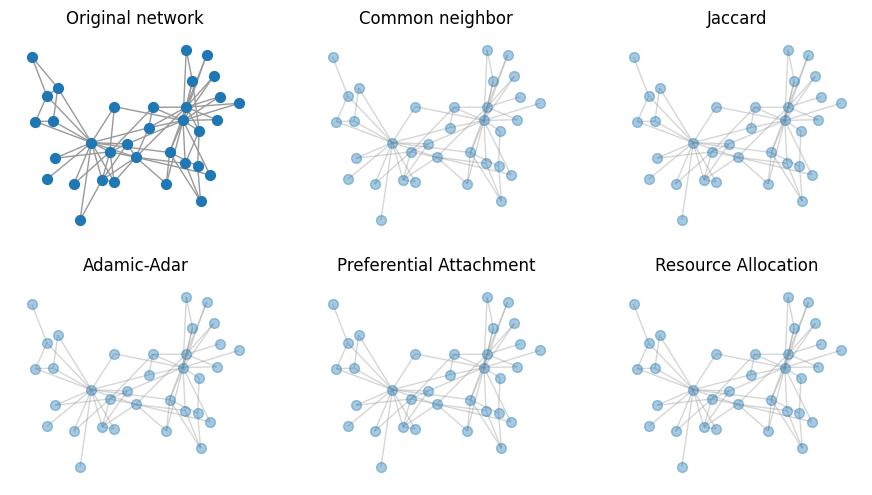

In [34]:
fig, ax = plt.subplots(2,3,figsize=(11,6),dpi=100)

# Original network
pos = nx.spring_layout(G_karate)
nx.draw(G_karate, pos, node_size=50, edge_color='.6', ax=ax[(0,0)])
ax[(0,0)].set_title('Original network')

#########################################

nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(0,1)], alpha=0.4)
G_tmp = nx.Graph()
G_tmp.add_nodes_from(G_karate.nodes())
# G_tmp.add_edges_from() ?????? add edges from 
# nx.draw(....., edge_color='orange', widths=2)
ax[(0,1)].set_title('Common neighbor')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(0,2)], alpha=0.4)
## ...
## ...
ax[(0,2)].set_title('Jaccard')



nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,0)], alpha=0.4)
## ...
## ...
ax[(1,0)].set_title('Adamic-Adar')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,1)], alpha=0.4)
## ...
## ...
ax[(1,1)].set_title('Preferential Attachment')


nx.draw(G_karate_train, pos, node_size=50, edge_color='.6', ax=ax[(1,2)], alpha=0.4)
## ...
## ...
ax[(1,2)].set_title('Resource Allocation')



plt.show()

On this small friendship network, methods that emphasize shared neighborhoods (such as common neighbors, Adamic-Adar, and resource allocation) tend to perform comparatively well. This contrasts with the disassortative stochastic block model example below, where the same heuristics can come close to random performance.

-------

## When local heuristics fail: a disassortative SBM

Neighborhood-based scores implicitly assume a kind of **homophily**: nodes with similar neighbors tend to connect. This is often reasonable (social networks, collaboration networks) but not universal.

To see a failure case, consider a simple stochastic block model (SBM) with two groups of equal size where edges are more likely between groups than within groups. In this disassortative setting, many new edges connect structurally dissimilar nodes, and local similarity measures can perform poorly.

In [35]:
# Disassortative SBM
sizes = [40, 40]
p = [[0.02, 0.15],
     [0.15, 0.02]]

G_sbm = nx.stochastic_block_model(sizes, p, seed=SEED)

G_sbm_train, test_sbm, neg_sbm = train_test_split_graph(
    G_sbm, test_frac=0.2, seed=SEED, ensure_connected=True
)

print("SBM (disassortative)")
print("  Nodes:", G_sbm.number_of_nodes())
print("  Edges:", G_sbm.number_of_edges())
print("  Test positives:", len(test_sbm))
print("  Test negatives:", len(neg_sbm))


SBM (disassortative)
  Nodes: 80
  Edges: 284
  Test positives: 56
  Test negatives: 56


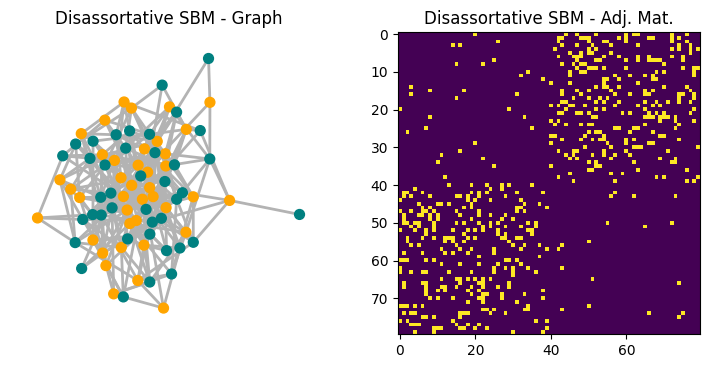

In [36]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=100)

nx.draw(G_sbm,node_size=50,width=2,edge_color='.7',
        node_color=['orange']*40+['teal']*40,ax=ax[0])
ax[1].imshow(nx.to_numpy_array(G_sbm))

ax[0].set_title('Disassortative SBM - Graph')
ax[1].set_title('Disassortative SBM - Adj. Mat.')

plt.show()

In [37]:
results = {}
for name, fn in [
    ("Common Neighb", common_neighbors_score),
    ("Jaccard Score", jaccard_score),
    ("Adamic-Adar", adamic_adar_score),
    ("Pref. Attach", preferential_attachment_score),
    ("Resour. Alloc", resource_allocation_score),
]:
    y, s, auc = evaluate_score_function(G_sbm_train, test_sbm, neg_sbm, fn, verbose=False)
    results[name] = (y, s, auc)


for name, (y, s, auc) in results.items():
    print(f"{name}:\t SBM ROC-AUC = {auc:.3f}")

Common Neighb:	 SBM ROC-AUC = 0.371
Jaccard Score:	 SBM ROC-AUC = 0.370
Adamic-Adar:	 SBM ROC-AUC = 0.363
Pref. Attach:	 SBM ROC-AUC = 0.538
Resour. Alloc:	 SBM ROC-AUC = 0.363


On this disassortative network, performance can be much closer to (or worse than!) random. This example underscores that link prediction methods are not universally reliable; they encode assumptions about how edges form.

### Homophily vs. yeterophily (bipartite networks, similarity/complementary)

- Homophily suggests that similar nodes are more likely to connect, whereas heterophily implies connections between dissimilar nodes.
- Homophily-based methods (like common neighbors or Jaccard) work well for networks where similar nodes are connected, but they struggle in heterophilic networks.
- For networks formed through heterophily (e.g., connections between dissimilar or complementary nodes), we might need different predictors or additional features (such as node attributes) to account for these dissimilarities.

There are some papers taking in consideration of such features, including: [Zheng at al, 2022](https://arxiv.org/abs/2202.07082), [Zhu et al., 2021](https://arxiv.org/abs/2009.13566), and [Kovacs et al, 2019](https://www.nature.com/articles/s41467-019-09177-y)

![](images/proteins.png)

---

## Two final points


### 1. Link prediction and sparsification: Remembering vs forgetting edges

There is a useful analogy between link prediction and the sparsification methods you saw earlier in the course.

In sparsification, we start from a dense graph $G = (V, E)$ and construct a sparser graph $\tilde{G} = (V, \tilde{E})$ that preserves certain structural properties while using far fewer edges. Conceptually, a sparsification algorithm assigns each edge $e \in E$ an importance score $w(e)$ and then keeps only the "most important" edges according to some criterion (for example, effective resistance, disparity filter weights, or spanning-tree structure). One can think of this as a principled form of **edge forgetting**: we deliberately throw away edges that the algorithm deems redundant for the structure we care about.

Link prediction reverses this perspective. Here, we start from an incomplete graph $G_{\text{train}}$ and ask which missing edges should be added back. We again assign a score $s(i, j)$ to each candidate non-edge $(i, j) \notin E_{\text{train}}$, and we treat the highest-scoring pairs as the most plausible edges. In this sense, link prediction is a form of **edge remembering**: given that some edges have been hidden or never observed, we try to reconstruct the subset that is most consistent with the observed structure.

This suggests a conceptual duality:

* Sparsification: start with $E$ and use scores on present edges to decide which ones to forget while preserving global structure.
* Link prediction: start with $E_{\text{train}}$ and use scores on absent edges to decide which ones to remember in order to reconstruct or extend the structure.

Both problems rely on the same underlying intuition about which edges are structurally important: edges that close many triangles, connect communities, or appear in many random-walk paths will tend to be both (i) retained by good sparsifiers and (ii) highly ranked by good link prediction algorithms. The same tools (local neighborhoods, random walks, generative models) can be viewed either as mechanisms for pruning edges or as mechanisms for filling them back in.


### 2. Link prediction and recommendation systems

It is useful to make explicit how link prediction relates to what is usually called "recommendation." Many recommender systems can be represented as a **bipartite graph** between a set of users $i$ and a set of items $I$. An edge $(u, i)$ indicates that user $u \in U$ has interacted with item $i \in I$ (watched a movie, purchased a product, clicked a link, followed an account, and so on). The goal of recommendation is then:

> For each user $u$, identify a small set of items $i$ such that the missing edges $(u, i)$ are most likely to appear in the future.

This is exactly a link prediction problem on a bipartite graph. The candidate set consists of all non-edges $(u, i)$ that are not currently observed; a recommendation algorithm assigns a score $s(u, i)$ to each candidate pair and returns the top-$k$ items per user. The evaluation metrics are essentially the same as in this chapter:

* ROC-AUC and related ranking metrics (such as average precision) measure how well the algorithm separates edges that will appear from those that will not.
* Precision@$k$ measures the fraction of recommended items that correspond to true future interactions.

The main differences are pragmatic rather than conceptual. Real recommendation systems must often cope with:

* extremely large candidate sets and severe class imbalance,
* side information about users and items (attributes, content, context),
* strong temporal and causal constraints (for example, avoiding using future interactions when training).

But at their core, many recommender algorithms—especially graph-based ones—are specialized link prediction methods applied to user-item interaction networks.

______________

<!-- ## 11. Hierarchical random graphs and missing links

The disassortative SBM example shows that simple local heuristics can struggle when the true edge-generation mechanism connects structurally dissimilar nodes. One way to address this is to fit a **generative model** that can represent both assortative and disassortative structure at multiple scales.

Clauset, Moore, and Newman (2008) introduce a **hierarchical random graph** (HRG) model for this purpose and use it to predict missing links in real networks. The key idea is to represent the network's organization by a rooted binary tree (a dendrogram). Each leaf corresponds to a node of the graph, and each internal node $r$ is associated with a connection probability $p_r$.

Given a dendrogram $D$ and probabilities ${p_r}$, the model generates a network as follows:

* For any pair of vertices $(i, j)$, find their lowest common ancestor $r = \mathrm{LCA}(i,j)$ in the dendrogram.
* Place an edge between $i$ and $j$ independently with probability $p_r$.

This defines a hierarchical random graph in which edge probabilities depend on how "closely related" two vertices are in the tree. The model can express:

* assortative structure when $p_r$ tends to be larger for internal nodes near the leaves, leading to dense connections within small, tight groups;
* disassortative structure when $p_r$ tends to be larger high in the tree, so that edges are more likely between large branches than within them;
* arbitrary mixtures of both, because each internal node has its own parameter $p_r$.

Formally, the likelihood of an observed adjacency matrix $A$ given $(D, {p_r})$ factorizes over internal nodes of the dendrogram. For each internal node $r$:

* let $L_r$ and $R_r$ be the numbers of leaves in its left and right subtrees,
* let $E_r$ be the number of observed edges whose endpoints fall in different subtrees at $r$.

Then the contribution of $r$ to the likelihood is
$$
\mathcal{L}*r
= p_r^{E_r},(1 - p_r)^{L_r R_r - E_r},
$$
and the full likelihood is
$$
\mathcal{L}(A \mid D, {p_r})
= \prod*{r} \mathcal{L}_r.
$$

Clauset et al. use maximum-likelihood and Monte Carlo procedures to **sample dendrograms** from the posterior distribution of $(D, {p_r})$ given the data. Once they have an ensemble of likely hierarchical models, they can perform link prediction as follows:

1. For each sampled model, compute the edge probability for a candidate pair $(i, j)$ as $p_{\mathrm{LCA}(i,j)}$.
2. Average these probabilities over many samples to obtain a score
   $$
   s(i, j) = \frac{1}{S}\sum_{s=1}^S p_{\mathrm{LCA}(i,j)}^{(s)}.
   $$
3. Rank all candidate pairs by $s(i, j)$, just as we did for local heuristics.

They evaluate this method on several empirical networks (a metabolic network, a terrorist association network, and a grassland food web), comparing AUC to baselines such as common neighbors, Jaccard, degree product, and shortest-path-based scores. For the grassland food web, the hierarchical model performs substantially better: local common-neighbor-based scores mistakenly predict edges between predators that share prey but do not prey on each other, whereas the hierarchical model correctly captures this disassortative structure.

This example illustrates two broader points:

* Topology alone can encode rich information: even without node attributes, a flexible generative model can capture multi-scale organization and support accurate link prediction.
* Model choice encodes assumptions: local similarity heuristics implicitly assume assortative, triangle-closing behavior, while hierarchical probabilistic models can represent a wider range of structures, including mixtures of assortative and disassortative patterns.
 -->

In this chapter, we treated link prediction as the problem of ranking node pairs according to how likely they are to form an edge, rather than as a simple yes/no classification task.

The story of link prediction has progressed far beyond the hand-crafted structural scores and simple baselines we covered today. Now, there are tons of modern machine-learning approaches to link prediction and graph representation learning. These include random-walk-based embeddings such as DeepWalk and node2vec, which learn vector representations of nodes by treating truncated walks as "sentences" (Perozzi et al., 2014; Grover and Leskovec, 2016), as well as graph neural network architectures like GCNs and GATs that learn to aggregate information from neighbors through trainable message-passing layers (Kipf and Welling, 2017; Veličković et al., 2018; Hamilton et al., 2017). There is also a growing literature on stacking and ensembling models for nearly optimal link prediction (Ghasemian et al., 2020) and on designing architectures that perform well on heterogeneous or heterophilous graphs (Dong et al., 2017; Wang et al., 2019; Fu et al., 2020; Zheng et al., 2022; Zhu et al., 2021). If you are interested in going beyond the classical heuristics and simple supervised baselines presented here, the references above provide a roadmap into this rapidly evolving area.


__________
## Next time...
Spatial Data, OSMNX, GeoPandas `class_24_spatial.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. Adamic, L. A., & Adar, E. (2003). Friends and neighbors on the web. *Social Networks*, 25(3), 211–230. https://doi.org/10.1016/S0378-8733(03)00009-1
3. Albert, R., & Barabási, A.-L. (2002). Statistical mechanics of complex networks. *Reviews of Modern Physics*, 74(1), 47–97. https://doi.org/10.1103/RevModPhys.74.47
4. Clauset, A., Moore, C., & Newman, M. E. J. (2008). Hierarchical structure and the prediction of missing links in networks. *Nature*, 453(7191), 98–101. https://doi.org/10.1038/nature06830
5. Fawcett, T. (2006). An introduction to ROC analysis. *Pattern Recognition Letters*, 27(8), 861–874. https://doi.org/10.1016/j.patrec.2005.10.010
6. Katz, L. (1953). A new status index derived from sociometric analysis. *Psychometrika*, 18(1), 39–43. https://doi.org/10.1007/BF02289026
7. Liben-Nowell, D., & Kleinberg, J. (2007). The link-prediction problem for social networks. *Journal of the American Society for Information Science and Technology*, 58(7), 1019–1031. https://doi.org/10.1002/asi.20591
8. Lü, L., & Zhou, T. (2011). Link prediction in complex networks: A survey. *Physica A: Statistical Mechanics and its Applications*, 390(6), 1150–1170. https://doi.org/10.1016/j.physa.2010.11.027
9. Newman, M. E. J. (2018). *Networks* (2nd ed.). Oxford University Press.
10. Ghasemian, A., Hosseinmardi, H., Galstyan, A., Airoldi, E. M., & Clauset, A. (2020). Stacking models for nearly optimal link prediction in complex networks. *Proceedings of the National Academy of Sciences of the United States of America*, 117(38), 23393–23400. https://doi.org/10.1073/pnas.1914950117
11. Newman, M. E. J., & Reinert, G. (2016). Estimating the number of communities in a network. *Physical Review Letters*, 117(7), 078301. https://doi.org/10.1103/PhysRevLett.117.078301
12. Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure in networks. *Physical Review E*, 69(2), 026113. https://doi.org/10.1103/PhysRevE.69.026113
13. Perozzi, B., Al-Rfou, R., & Skiena, S. (2014). DeepWalk: Online learning of social representations. In *Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’14)* (pp. 701–710). https://doi.org/10.1145/2623330.2623732
14. Grover, A., & Leskovec, J. (2016). node2vec: Scalable feature learning for networks. In *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’16)* (pp. 855–864). https://doi.org/10.1145/2939672.2939754
15. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). Graph attention networks. In *International Conference on Learning Representations (ICLR 2018)*. arXiv:1710.10903. https://arxiv.org/abs/1710.10903
16. Kipf, T. N., & Welling, M. (2017). Semi-supervised classification with graph convolutional networks. In *International Conference on Learning Representations (ICLR 2017)*. arXiv:1609.02907. https://arxiv.org/abs/1609.02907
17. Hamilton, W. L., Ying, R., & Leskovec, J. (2017). Inductive representation learning on large graphs. In *Advances in Neural Information Processing Systems (NeurIPS 2017)* (pp. 1025–1035). arXiv:1706.02216. https://arxiv.org/abs/1706.02216
18. Dong, Y., Chawla, N. V., & Swami, A. (2017). metapath2vec: Scalable representation learning for heterogeneous networks. In *Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’17)* (pp. 135–144). https://doi.org/10.1145/3097983.3098036
19. Wang, X., Ji, H., Shi, C., Wang, B., Ye, Y., Cui, P., & Yu, P. S. (2019). Heterogeneous graph attention network. In *Proceedings of the World Wide Web Conference (WWW 2019)* (pp. 2022–2032). https://doi.org/10.1145/3308558.3313562
20. Fu, X., Zhang, J., Meng, Z., & King, I. (2020). MAGNN: Metapath aggregated graph neural network for heterogeneous graph embedding. In *Proceedings of the Web Conference 2020 (WWW ’20)* (pp. 2331–2341). https://doi.org/10.1145/3366423.3380297
21. Zheng, X., Wang, Y., Liu, Y., Li, M., Zhang, M., Jin, D., Yu, P. S., & Pan, S. (2022). Graph neural networks for graphs with heterophily: A survey. *arXiv preprint* arXiv:2202.07082. https://arxiv.org/abs/2202.07082
22. Zhu, J., Rossi, R. A., Rao, A., Mai, T., Lipka, N., Ahmed, N. K., & Koutra, D. (2021). Graph neural networks with heterophily. *Proceedings of the AAAI Conference on Artificial Intelligence*, 35(12), 11168–11176. https://doi.org/10.1609/aaai.v35i12.17332